In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
tf.random.set_seed(1)
random.seed(1)

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
height = 512

In [4]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
valdataset = DatasetCreator(val_transforms)

In [6]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [7]:
trainaugmentation = albu.Compose([
    albu.Resize(height, height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],always_apply=True)
])#todo change later

In [8]:
traindataset = DatasetCreator(trainaugmentation)

In [9]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

20

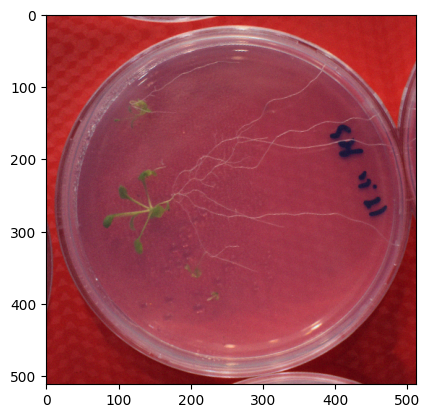

tf.Tensor(
[[[[ 0.8618032  -1.3704481  -1.3687146 ]
   [ 0.82755363 -1.3879551  -1.5430064 ]
   [ 0.9474269  -1.405462   -1.4035729 ]
   ...
   [ 1.221423   -1.3354341  -1.4210021 ]
   [ 0.98167646 -1.30042    -1.3861437 ]
   [ 1.221423   -1.247899   -1.3861437 ]]

  [[ 0.9645517  -1.3179271  -1.2641394 ]
   [ 0.9645517  -1.3354341  -1.4210021 ]
   [ 0.75905466 -1.405462   -1.2989978 ]
   ...
   [ 1.152924   -1.3879551  -1.229281  ]
   [ 1.0501754  -1.352941   -1.316427  ]
   [ 1.1357992  -1.3179271  -1.4035729 ]]

  [[ 0.87892795 -1.30042    -1.4558605 ]
   [ 0.9303022  -1.5105041  -1.3861437 ]
   [ 0.82755363 -1.3354341  -1.4384313 ]
   ...
   [ 1.2385477  -1.352941   -1.3512853 ]
   [ 1.152924   -1.3879551  -1.2467102 ]
   [ 1.1186745  -1.4404761  -1.2641394 ]]

  ...

  [[ 0.2281873  -1.7030811  -1.7347276 ]
   [ 0.27956155 -1.6155461  -1.6301525 ]
   [ 0.41655958 -1.685574   -1.7172984 ]
   ...
   [ 0.2624368  -1.6155461  -1.5255773 ]
   [ 0.14256352 -1.7380952  -1.6650108 ]
   [ 

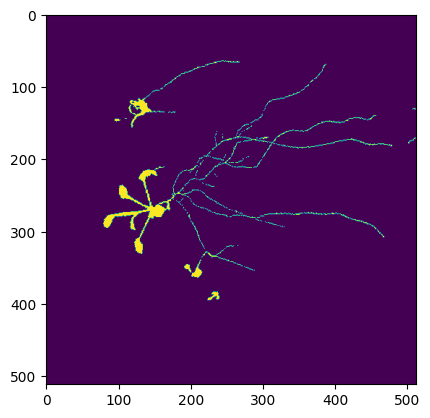

In [10]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(image)

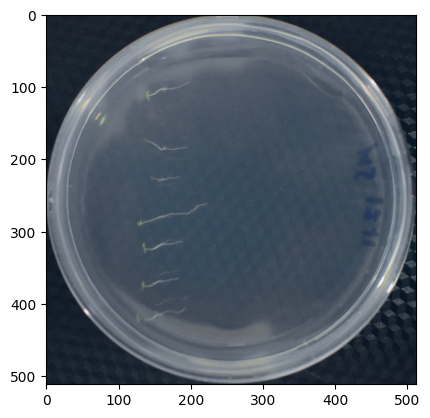

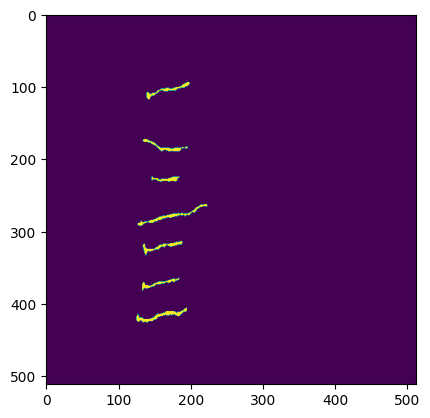

In [11]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [12]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_5/Sigmoid:0', description="created by layer 'conv2d_transpose_5'")


In [13]:
model.save('testovik.h5')

In [14]:
#tf.keras.utils.plot_model(model)

In [15]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [16]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000


20/20 [==============================] - ETA: 0s - loss: 3.2848 - iou_score: 0.0086
Epoch 1: val_loss improved from inf to 11.36351, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 28s 620ms/step - loss: 3.2848 - iou_score: 0.0086 - val_loss: 11.3635 - val_iou_score: 0.0097 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 1.6481 - iou_score: 0.0077
Epoch 2: val_loss improved from 11.36351 to 7.13787, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 497ms/step - loss: 1.6481 - iou_score: 0.0077 - val_loss: 7.1379 - val_iou_score: 0.0095 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 1.2980 - iou_score: 0.0080
Epoch 3: val_loss improved from 7.13787 to 3.65397, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 506ms/step - loss: 1.2980 - iou_score: 0.0080 - val_loss: 3.6540 - val_iou_score: 0.0093 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 1.1538 - iou_score: 0.0082
Epoch 4: val_loss improved from 3.65397 to 2.32104, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 498ms/step - loss: 1.1538 - iou_score: 0.0082 - val_loss: 2.3210 - val_iou_score: 0.0107 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 1.0891 - iou_score: 0.0094
Epoch 5: val_loss improved from 2.32104 to 1.22276, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 497ms/step - loss: 1.0891 - iou_score: 0.0094 - val_loss: 1.2228 - val_iou_score: 0.0135 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 1.0520 - iou_score: 0.0101
Epoch 6: val_loss did not improve from 1.22276
20/20 [==============================] - 14s 260ms/step - loss: 1.0520 - iou_score: 0.0101 - val_loss: 1.3759 - val_iou_score: 0.0152 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 1.0474 - iou_score: 0.0122
Epoch 7: val_loss improved from 1.22276 to 1.00875, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 1.0474 - iou_score: 0.0122 - val_loss: 1.0087 - val_iou_score: 0.0182 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 1.0283 - iou_score: 0.0131
Epoch 8: val_loss improved from 1.00875 to 0.96813, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 502ms/step - loss: 1.0283 - iou_score: 0.0131 - val_loss: 0.9681 - val_iou_score: 0.0215 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 1.0120 - iou_score: 0.0144
Epoch 9: val_loss improved from 0.96813 to 0.95499, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 491ms/step - loss: 1.0120 - iou_score: 0.0144 - val_loss: 0.9550 - val_iou_score: 0.0283 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 0.9990 - iou_score: 0.0160
Epoch 10: val_loss improved from 0.95499 to 0.95319, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 500ms/step - loss: 0.9990 - iou_score: 0.0160 - val_loss: 0.9532 - val_iou_score: 0.0285 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: 0.9899 - iou_score: 0.0205
Epoch 11: val_loss did not improve from 0.95319
20/20 [==============================] - 14s 257ms/step - loss: 0.9899 - iou_score: 0.0205 - val_loss: 0.9548 - val_iou_score: 0.0348 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
20/20 [==============================] - ETA: 0s - loss: 0.9944 - iou_score: 0.0207
Epoch 12: val_loss improved from 0.95319 to 0.93569, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 502ms/step - loss: 0.9944 - iou_score: 0.0207 - val_loss: 0.9357 - val_iou_score: 0.0399 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
20/20 [==============================] - ETA: 0s - loss: 0.9669 - iou_score: 0.0315
Epoch 13: val_loss improved from 0.93569 to 0.91360, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.9669 - iou_score: 0.0315 - val_loss: 0.9136 - val_iou_score: 0.0560 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 0.9551 - iou_score: 0.0379
Epoch 14: val_loss improved from 0.91360 to 0.91061, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.9551 - iou_score: 0.0379 - val_loss: 0.9106 - val_iou_score: 0.0654 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 0.9945 - iou_score: 0.0404
Epoch 15: val_loss did not improve from 0.91061
20/20 [==============================] - 15s 257ms/step - loss: 0.9945 - iou_score: 0.0404 - val_loss: 1.0986 - val_iou_score: 0.0556 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 0.9474 - iou_score: 0.0530
Epoch 16: val_loss improved from 0.91061 to 0.89128, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 497ms/step - loss: 0.9474 - iou_score: 0.0530 - val_loss: 0.8913 - val_iou_score: 0.0924 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
20/20 [==============================] - ETA: 0s - loss: 0.9230 - iou_score: 0.0584
Epoch 17: val_loss improved from 0.89128 to 0.81229, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 18s 509ms/step - loss: 0.9230 - iou_score: 0.0584 - val_loss: 0.8123 - val_iou_score: 0.1257 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
20/20 [==============================] - ETA: 0s - loss: 0.8686 - iou_score: 0.0877
Epoch 18: val_loss improved from 0.81229 to 0.73864, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.8686 - iou_score: 0.0877 - val_loss: 0.7386 - val_iou_score: 0.1567 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/1000
20/20 [==============================] - ETA: 0s - loss: 0.8305 - iou_score: 0.1078
Epoch 19: val_loss improved from 0.73864 to 0.68301, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.8305 - iou_score: 0.1078 - val_loss: 0.6830 - val_iou_score: 0.1946 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 0.8222 - iou_score: 0.1193
Epoch 20: val_loss improved from 0.68301 to 0.64963, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 499ms/step - loss: 0.8222 - iou_score: 0.1193 - val_loss: 0.6496 - val_iou_score: 0.2254 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 0.7649 - iou_score: 0.1570
Epoch 21: val_loss improved from 0.64963 to 0.61401, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 503ms/step - loss: 0.7649 - iou_score: 0.1570 - val_loss: 0.6140 - val_iou_score: 0.2559 - lr: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 0.7711 - iou_score: 0.1542
Epoch 22: val_loss improved from 0.61401 to 0.60858, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 503ms/step - loss: 0.7711 - iou_score: 0.1542 - val_loss: 0.6086 - val_iou_score: 0.2506 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 0.7301 - iou_score: 0.1733
Epoch 23: val_loss improved from 0.60858 to 0.55607, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 484ms/step - loss: 0.7301 - iou_score: 0.1733 - val_loss: 0.5561 - val_iou_score: 0.2970 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 0.6847 - iou_score: 0.2050
Epoch 24: val_loss improved from 0.55607 to 0.53289, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 499ms/step - loss: 0.6847 - iou_score: 0.2050 - val_loss: 0.5329 - val_iou_score: 0.3084 - lr: 0.0010

Epoch 25: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 25/1000
20/20 [==============================] - ETA: 0s - loss: 0.6620 - iou_score: 0.2260
Epoch 25: val_loss improved from 0.53289 to 0.51458, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.6620 - iou_score: 0.2260 - val_loss: 0.5146 - val_iou_score: 0.3481 - lr: 0.0010

Epoch 26: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: 0.6382 - iou_score: 0.2387
Epoch 26: val_loss improved from 0.51458 to 0.45892, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 503ms/step - loss: 0.6382 - iou_score: 0.2387 - val_loss: 0.4589 - val_iou_score: 0.3915 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 27/1000
20/20 [==============================] - ETA: 0s - loss: 0.5887 - iou_score: 0.2800
Epoch 27: val_loss improved from 0.45892 to 0.42429, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 504ms/step - loss: 0.5887 - iou_score: 0.2800 - val_loss: 0.4243 - val_iou_score: 0.4024 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 28/1000
20/20 [==============================] - ETA: 0s - loss: 0.5907 - iou_score: 0.2843
Epoch 28: val_loss did not improve from 0.42429
20/20 [==============================] - 15s 261ms/step - loss: 0.5907 - iou_score: 0.2843 - val_loss: 0.4291 - val_iou_score: 0.4035 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 29/1000
20/20 [==============================] - ETA: 0s - loss: 0.5659 - iou_score: 0.2934
Epoch 29: val_loss did not improve from 0.42429
20/20 [==============================] - 14s 261ms/step - loss: 0.5659 - iou_score: 0.2934 - val_loss: 0.4404 - val_iou_score: 0.3960 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 30/1000
20/20 [===

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 500ms/step - loss: 0.5629 - iou_score: 0.3028 - val_loss: 0.4081 - val_iou_score: 0.4246 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 0.5539 - iou_score: 0.3072
Epoch 31: val_loss improved from 0.40811 to 0.39451, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 503ms/step - loss: 0.5539 - iou_score: 0.3072 - val_loss: 0.3945 - val_iou_score: 0.4524 - lr: 9.0484e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 0.5267 - iou_score: 0.3292
Epoch 32: val_loss did not improve from 0.39451
20/20 [==============================] - 14s 256ms/step - loss: 0.5267 - iou_score: 0.3292 - val_loss: 0.3969 - val_iou_score: 0.4535 - lr: 9.0484e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 0.5005 - iou_score: 0.3526
Epoch 33: val_loss improved from 0.39451 to 0.37213, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 500ms/step - loss: 0.5005 - iou_score: 0.3526 - val_loss: 0.3721 - val_iou_score: 0.4727 - lr: 9.0484e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 34/1000
20/20 [==============================] - ETA: 0s - loss: 0.5168 - iou_score: 0.3408
Epoch 34: val_loss did not improve from 0.37213
20/20 [==============================] - 15s 258ms/step - loss: 0.5168 - iou_score: 0.3408 - val_loss: 0.3849 - val_iou_score: 0.4483 - lr: 9.0484e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 35/1000
20/20 [==============================] - ETA: 0s - loss: 0.4674 - iou_score: 0.3767
Epoch 35: val_loss did not improve from 0.37213
20/20 [==============================] - 14s 255ms/step - loss: 0.4674 - iou_score: 0.3767 - val_loss: 0.4198 - val_iou_score: 0.4330 - lr: 9.0484e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 36/100

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 504ms/step - loss: 0.5292 - iou_score: 0.3314 - val_loss: 0.3583 - val_iou_score: 0.4858 - lr: 9.0484e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 38/1000
20/20 [==============================] - ETA: 0s - loss: 0.5141 - iou_score: 0.3421
Epoch 38: val_loss improved from 0.35830 to 0.34251, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 491ms/step - loss: 0.5141 - iou_score: 0.3421 - val_loss: 0.3425 - val_iou_score: 0.5046 - lr: 9.0484e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 39/1000
20/20 [==============================] - ETA: 0s - loss: 0.4757 - iou_score: 0.3749
Epoch 39: val_loss did not improve from 0.34251
20/20 [==============================] - 14s 257ms/step - loss: 0.4757 - iou_score: 0.3749 - val_loss: 0.3515 - val_iou_score: 0.4925 - lr: 9.0484e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 40/1000
20/20 [==============================] - ETA: 0s - loss: 0.4832 - iou_score: 0.3663
Epoch 40: val_loss improved from 0.34251 to 0.32809, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 503ms/step - loss: 0.4832 - iou_score: 0.3663 - val_loss: 0.3281 - val_iou_score: 0.5205 - lr: 9.0484e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 0.4869 - iou_score: 0.3616
Epoch 41: val_loss did not improve from 0.32809
20/20 [==============================] - 15s 260ms/step - loss: 0.4869 - iou_score: 0.3616 - val_loss: 0.3819 - val_iou_score: 0.4704 - lr: 9.0484e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 0.4830 - iou_score: 0.3697
Epoch 42: val_loss did not improve from 0.32809
20/20 [==============================] - 14s 262ms/step - loss: 0.4830 - iou_score: 0.3697 - val_loss: 0.4364 - val_iou_score: 0.4196 - lr: 9.0484e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 43/100

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 497ms/step - loss: 0.4173 - iou_score: 0.4297 - val_loss: 0.3208 - val_iou_score: 0.5332 - lr: 8.1873e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: 0.4837 - iou_score: 0.3659
Epoch 51: val_loss did not improve from 0.32083
20/20 [==============================] - 14s 261ms/step - loss: 0.4837 - iou_score: 0.3659 - val_loss: 0.3752 - val_iou_score: 0.4690 - lr: 8.1873e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 52/1000
20/20 [==============================] - ETA: 0s - loss: 0.4663 - iou_score: 0.3801
Epoch 52: val_loss did not improve from 0.32083
20/20 [==============================] - 14s 260ms/step - loss: 0.4663 - iou_score: 0.3801 - val_loss: 0.3914 - val_iou_score: 0.4645 - lr: 8.1873e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 53/100

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 18s 502ms/step - loss: 0.4814 - iou_score: 0.3651 - val_loss: 0.3187 - val_iou_score: 0.5316 - lr: 8.1873e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 54/1000
20/20 [==============================] - ETA: 0s - loss: 0.4691 - iou_score: 0.3788
Epoch 54: val_loss improved from 0.31868 to 0.31672, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 18s 499ms/step - loss: 0.4691 - iou_score: 0.3788 - val_loss: 0.3167 - val_iou_score: 0.5426 - lr: 8.1873e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 55/1000
20/20 [==============================] - ETA: 0s - loss: 0.4620 - iou_score: 0.3920
Epoch 55: val_loss did not improve from 0.31672
20/20 [==============================] - 14s 259ms/step - loss: 0.4620 - iou_score: 0.3920 - val_loss: 0.3177 - val_iou_score: 0.5340 - lr: 8.1873e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 56/1000
20/20 [==============================] - ETA: 0s - loss: 0.4240 - iou_score: 0.4280
Epoch 56: val_loss did not improve from 0.31672
20/20 [==============================] - 14s 260ms/step - loss: 0.4240 - iou_score: 0.4280 - val_loss: 0.3304 - val_iou_score: 0.5164 - lr: 8.1873e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 57/100

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 500ms/step - loss: 0.4403 - iou_score: 0.4083 - val_loss: 0.3065 - val_iou_score: 0.5458 - lr: 8.1873e-04

Epoch 61: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 61/1000
20/20 [==============================] - ETA: 0s - loss: 0.4365 - iou_score: 0.4114
Epoch 61: val_loss did not improve from 0.30645
20/20 [==============================] - 14s 259ms/step - loss: 0.4365 - iou_score: 0.4114 - val_loss: 0.3338 - val_iou_score: 0.5107 - lr: 7.4082e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 62/1000
20/20 [==============================] - ETA: 0s - loss: 0.4338 - iou_score: 0.4173
Epoch 62: val_loss did not improve from 0.30645
20/20 [==============================] - 14s 261ms/step - loss: 0.4338 - iou_score: 0.4173 - val_loss: 0.3284 - val_iou_score: 0.5208 - lr: 7.4082e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 63/1000
2

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 502ms/step - loss: 0.4138 - iou_score: 0.4345 - val_loss: 0.3043 - val_iou_score: 0.5483 - lr: 7.4082e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 65/1000
20/20 [==============================] - ETA: 0s - loss: 0.4063 - iou_score: 0.4404
Epoch 65: val_loss did not improve from 0.30430
20/20 [==============================] - 14s 261ms/step - loss: 0.4063 - iou_score: 0.4404 - val_loss: 0.3165 - val_iou_score: 0.5348 - lr: 7.4082e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 66/1000
20/20 [==============================] - ETA: 0s - loss: 0.4342 - iou_score: 0.4122
Epoch 66: val_loss did not improve from 0.30430
20/20 [==============================] - 14s 260ms/step - loss: 0.4342 - iou_score: 0.4122 - val_loss: 0.3123 - val_iou_score: 0.5457 - lr: 7.4082e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 67/1000
2

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 502ms/step - loss: 0.4025 - iou_score: 0.4418 - val_loss: 0.2989 - val_iou_score: 0.5553 - lr: 7.4082e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 69/1000
20/20 [==============================] - ETA: 0s - loss: 0.4017 - iou_score: 0.4439
Epoch 69: val_loss did not improve from 0.29887
20/20 [==============================] - 14s 261ms/step - loss: 0.4017 - iou_score: 0.4439 - val_loss: 0.3026 - val_iou_score: 0.5514 - lr: 7.4082e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 0.4067 - iou_score: 0.4438
Epoch 70: val_loss did not improve from 0.29887
20/20 [==============================] - 14s 258ms/step - loss: 0.4067 - iou_score: 0.4438 - val_loss: 0.3164 - val_iou_score: 0.5352 - lr: 7.4082e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 71/1000
2

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.4220 - iou_score: 0.4285 - val_loss: 0.2896 - val_iou_score: 0.5652 - lr: 6.7032e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 78/1000
20/20 [==============================] - ETA: 0s - loss: 0.3980 - iou_score: 0.4455
Epoch 78: val_loss did not improve from 0.28961
20/20 [==============================] - 15s 260ms/step - loss: 0.3980 - iou_score: 0.4455 - val_loss: 0.2943 - val_iou_score: 0.5631 - lr: 6.7032e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 79/1000
20/20 [==============================] - ETA: 0s - loss: 0.3860 - iou_score: 0.4635
Epoch 79: val_loss did not improve from 0.28961
20/20 [==============================] - 15s 260ms/step - loss: 0.3860 - iou_score: 0.4635 - val_loss: 0.2954 - val_iou_score: 0.5681 - lr: 6.7032e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 80/1000
2

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.3937 - iou_score: 0.4610 - val_loss: 0.2889 - val_iou_score: 0.5657 - lr: 6.7032e-04

Epoch 84: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 84/1000
20/20 [==============================] - ETA: 0s - loss: 0.4036 - iou_score: 0.4438
Epoch 84: val_loss improved from 0.28891 to 0.28445, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 501ms/step - loss: 0.4036 - iou_score: 0.4438 - val_loss: 0.2844 - val_iou_score: 0.5795 - lr: 6.7032e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 85/1000
20/20 [==============================] - ETA: 0s - loss: 0.4195 - iou_score: 0.4304
Epoch 85: val_loss did not improve from 0.28445
20/20 [==============================] - 14s 259ms/step - loss: 0.4195 - iou_score: 0.4304 - val_loss: 0.3193 - val_iou_score: 0.5300 - lr: 6.7032e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 86/1000
20/20 [==============================] - ETA: 0s - loss: 0.3832 - iou_score: 0.4637
Epoch 86: val_loss did not improve from 0.28445
20/20 [==============================] - 13s 260ms/step - loss: 0.3832 - iou_score: 0.4637 - val_loss: 0.3086 - val_iou_score: 0.5427 - lr: 6.7032e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 87/1000
2

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 18s 493ms/step - loss: 0.3818 - iou_score: 0.4641 - val_loss: 0.2833 - val_iou_score: 0.5754 - lr: 6.0653e-04

Epoch 92: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 92/1000
20/20 [==============================] - ETA: 0s - loss: 0.3998 - iou_score: 0.4481
Epoch 92: val_loss did not improve from 0.28333
20/20 [==============================] - 15s 260ms/step - loss: 0.3998 - iou_score: 0.4481 - val_loss: 0.2934 - val_iou_score: 0.5709 - lr: 6.0653e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 93/1000
20/20 [==============================] - ETA: 0s - loss: 0.3748 - iou_score: 0.4715
Epoch 93: val_loss did not improve from 0.28333
20/20 [==============================] - 14s 261ms/step - loss: 0.3748 - iou_score: 0.4715 - val_loss: 0.2995 - val_iou_score: 0.5615 - lr: 6.0653e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 94/100

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 503ms/step - loss: 0.3770 - iou_score: 0.4727 - val_loss: 0.2727 - val_iou_score: 0.5853 - lr: 6.0653e-04

Epoch 100: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 100/1000
20/20 [==============================] - ETA: 0s - loss: 0.3948 - iou_score: 0.4519
Epoch 100: val_loss did not improve from 0.27269
20/20 [==============================] - 14s 262ms/step - loss: 0.3948 - iou_score: 0.4519 - val_loss: 0.2866 - val_iou_score: 0.5693 - lr: 6.0653e-04

Epoch 101: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 101/1000
20/20 [==============================] - ETA: 0s - loss: 0.3880 - iou_score: 0.4596
Epoch 101: val_loss did not improve from 0.27269
20/20 [==============================] - 14s 260ms/step - loss: 0.3880 - iou_score: 0.4596 - val_loss: 0.2746 - val_iou_score: 0.5879 - lr: 6.0653e-04

Epoch 102: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


20/20 [==============================] - 19s 502ms/step - loss: 0.3718 - iou_score: 0.4758 - val_loss: 0.2684 - val_iou_score: 0.5899 - lr: 6.0653e-04

Epoch 106: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 106/1000
20/20 [==============================] - ETA: 0s - loss: 0.3791 - iou_score: 0.4673
Epoch 106: val_loss did not improve from 0.26837
20/20 [==============================] - 14s 260ms/step - loss: 0.3791 - iou_score: 0.4673 - val_loss: 0.2759 - val_iou_score: 0.5825 - lr: 5.4881e-04

Epoch 107: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 107/1000
20/20 [==============================] - ETA: 0s - loss: 0.3872 - iou_score: 0.4611
Epoch 107: val_loss did not improve from 0.26837
20/20 [==============================] - 14s 262ms/step - loss: 0.3872 - iou_score: 0.4611 - val_loss: 0.2996 - val_iou_score: 0.5542 - lr: 5.4881e-04

Epoch 108: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch

In [17]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [18]:
results = model.evaluate(testdata)
results

10/10 [==============================] - 1s 17ms/step - loss: 0.3015 - iou_score: 0.5658


[0.3014904856681824, 0.5658320784568787]

In [19]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 21ms/step
